# Lliurament 3. Regressió

Aquesta és la tasca del tercer lliurament de Sistemes d'Aprenentatge Automàtic.

Aplicarem a unes mateixes dades tres mètodes de regressió: regressió lineal simple, regressió robusta amb RANSAC i regressió amb arbres.

Té setze apartats preguntes que puntuen tots igual: $0.625$ punts cadascun.

Preneu com a guia el següent **[quadern de regressió](https://colab.research.google.com/drive/1EBCxdZ-VD_xPzKIbuLg1NSZj74hKWXiw?usp=sharing)**.

## 1. Preparació de les dades

a) Carregau el conjunt de dades Boston Housing.

b) Considerau $x$ el nombre de cambres i $y$ el preu de l'habitatge.

c) Representau la gràfica d'$y$ en funció de $x$ sense escalar.

d) Obteniu versions escalades de les variables $x$ i $y$, amb els noms $x\_std$ i $y\_std$.


In [190]:
# a) Cargar los datos del conjunto Boston Housing
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"

df = pd.read_csv(data_url, sep="\s+", engine='python', skiprows=22, header=None)
print(df.size)

data=np.hstack([df.values[::2,0:11], df.values[1::2,0:3]])

columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PRATIO', 'B', 'LSTAT', 'MEDV']

df=pd.DataFrame(data,columns=columns)

df.head()

11132


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


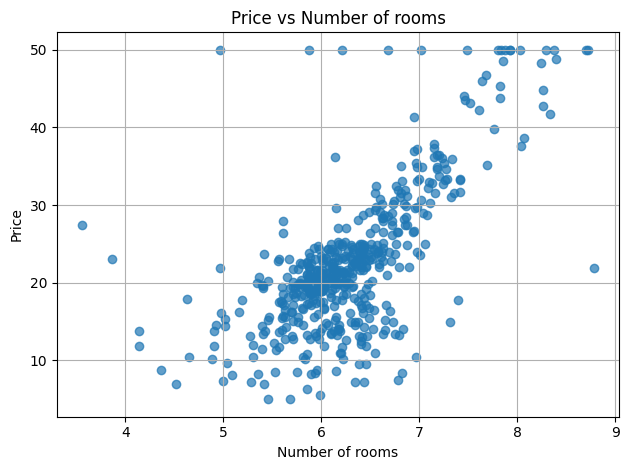

In [191]:
X = df['RM']
y = df['MEDV']

# c) Representar gráficamente y en función de X sin escalar
import matplotlib.pyplot as plt

plt.scatter(X, y, alpha=0.7)
plt.xlabel('Number of rooms')
plt.ylabel('Price')
plt.title('Price vs Number of rooms')

# Agregar líneas de cuadrícula
plt.grid(True)

plt.tight_layout()
plt.show()


# d) Obtener versiones escaladas de X e y
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_std = scaler.fit_transform(X.values.reshape(-1, 1))
y_std = scaler.fit_transform(y.values.reshape(-1, 1))

## 2. Regressió lineal

a) Ajustau un predictor lineal a les variables d'entrada i sortida escalades.

b) Obteniu el valor de l'entrada escalada $x\_std$ quan $x=6$ cambres.

c) Amb el model de predicció, obteniu el valor de la sortida escalada $y\_std$.

d) Desescalau la sortida per obtenir el preu. Quin és el preu predit per a un habitatge de $6$ cambres? Contrastau el vostre resultat a la gràfica de l'apartat 1c, per confirmar que té sentit.

In [192]:
# a) Ajustar un predictor lineal a los datos escalados
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_std, y_std)

# b) Obtener el valor de X_std cuando X = 6 habitaciones
X_6_std = scaler.transform(np.array([[6]]))


# c) Obtener el valor de la salida escalada 'y_std' usando el predictor lineal
y_6_pred_std = lin_reg.predict(X_6_std)

# d) Desescalar el valor de la salida
y_6_pred = scaler.inverse_transform(y_6_pred_std)
print("Predicted price for 6 rooms: ", y_6_pred[0][0])

Predicted price for 6 rooms:  11.036554993633077


### Conclusión:

La predicción de 11.03€ para una vivienda de 6 habitaciones se encuentra aproximadamente dentro del rango de precios que podemos observar en la gráfica. Esto sugiere que el modelo de regresión lineal ha ajustado correctamente la tendencia de los datos, y la predicción para 6 habitaciones tiene sentido pero no con una gran exactitud. Esto lo digo porque, debido a hay algunos cúmulos de puntos en la gráfica, es muy difícil distinguir de manera visual el dato buscado.

## 3. RANSAC

Hi ha una sèrie de dades fora del núvol central. Per això és adequat usar un sistema de regressió robusta. Proposau valors del llindar per aconseguir diferents proporcions de punts com a *inliers*.

a) Obteniu tres llindars (*threshold*) diferents, que ajustin la recta a aproximadament una quarta part dels punts, la meitat dels punts i tres quartes parts dels punts.

b) Representau gràficament les tres situacions de l'apartat anterior.

c) Obteniu les tres prediccions del preu de l'habitatge de quatre cambres segons els tres models.

d) Comentau la diferència entre els tres resultats d'aquesta pregunta i comparau-los també amb el resultat de la pregunta anterior. Se semblen bastant les prediccions? Són molt diferents?

In [193]:
# a) Obtener tres valores de umbral diferentes, ajustando la recta en una cuarta parte (25%), la mitad (50%) y tres cuartos (75%) de los datos
from sklearn.linear_model import RANSACRegressor
threshold_values = [0.12, 0.29, 0.64] # Cambiar estos valores para obtener diferentes umbrales
inliers_proportions = []

for threshold in threshold_values:
  ransac = RANSACRegressor(LinearRegression(), max_trials=1000, min_samples=50, loss='absolute_error', residual_threshold=threshold, random_state=0)
  ransac.fit(X_std, y_std)

  inlier_mask = ransac.inlier_mask_
  outlier_mask = np.logical_not(inlier_mask)

  inliers = np.sum(inlier_mask)
  total_points = len(X_std)
  proportion = inliers / total_points
  inliers_proportions.append(proportion)

  print(f"Threshold: {threshold}, Inliers: {inliers}, Total points: {total_points}, Proportion: {proportion * 100:.0f} %")

Threshold: 0.12, Inliers: 127, Total points: 506, Proportion: 25 %
Threshold: 0.29, Inliers: 254, Total points: 506, Proportion: 50 %
Threshold: 0.64, Inliers: 381, Total points: 506, Proportion: 75 %


Vemos el resultado de las configuraciones del threshold y su porcentaje respecto a los datos.
En el siguiente bloque de código se puede ver que el bucle se repite pero esta vez para representar gráficamente las tres situaciones.

Soy consciente de que lo recomendable sería usar el mismo bucle para realizar las dos acciones, pero he preferido mantenerlo así para que sea más fácil de entender y de ver las diferencias entre las configuraciones.

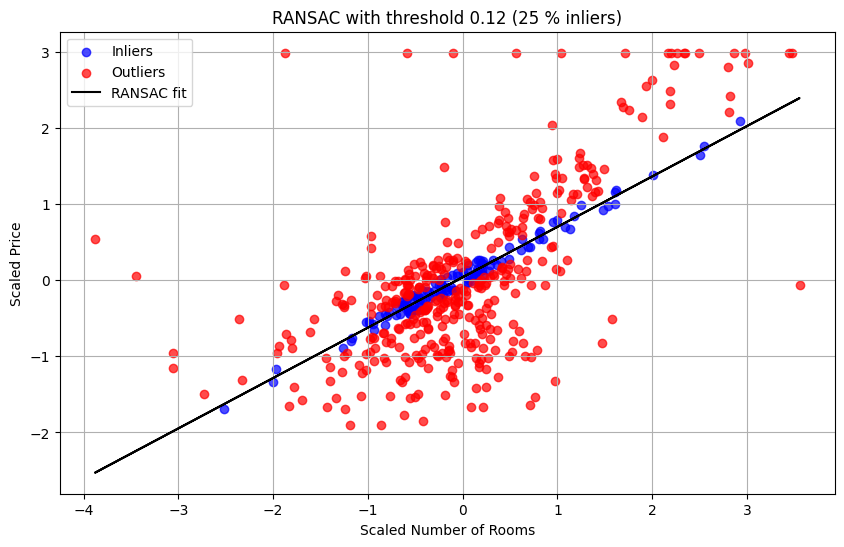

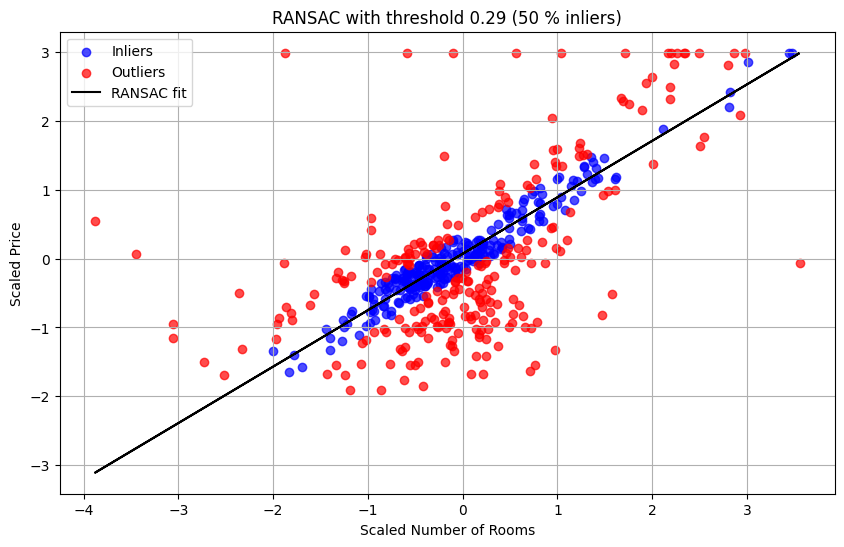

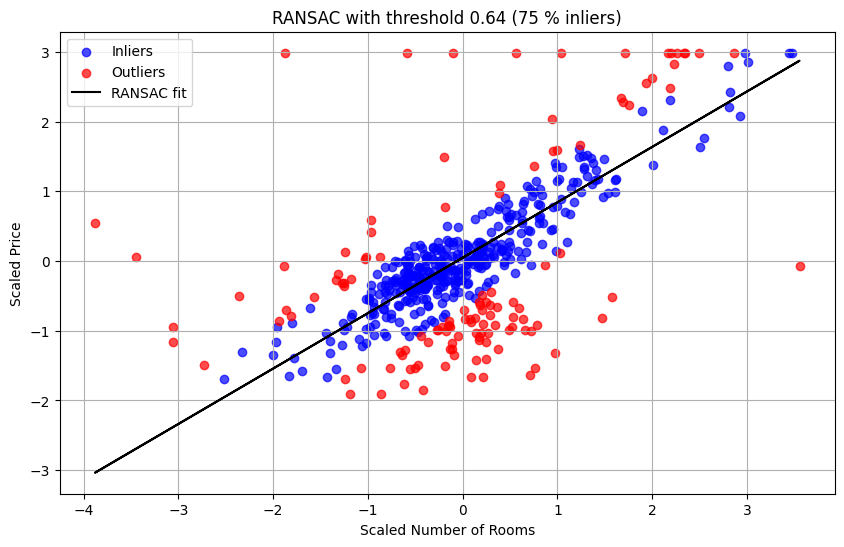

In [194]:
# b) Representar gráficamente los datos y las rectas ajustadas
for threshold in threshold_values:
  ransac = RANSACRegressor(LinearRegression(), max_trials=1000, min_samples=50, loss='absolute_error', residual_threshold=threshold, random_state=0)
  ransac.fit(X_std, y_std)

  inlier_mask = ransac.inlier_mask_
  outlier_mask = np.logical_not(inlier_mask)

  inliers = np.sum(inlier_mask)
  total_points = len(X_std)
  proportion = inliers / total_points
  inliers_proportions.append(proportion)

  plt.figure(figsize=(10, 6))
  plt.scatter(X_std[inlier_mask], y_std[inlier_mask], color='blue', label='Inliers', alpha=0.7)
  plt.scatter(X_std[~inlier_mask], y_std[~inlier_mask], color='red', label='Outliers', alpha=0.7)
  plt.plot(X_std, ransac.predict(X_std), color='black', label='RANSAC fit')
  plt.xlabel("Scaled Number of Rooms")
  plt.ylabel("Scaled Price")
  plt.title(f"RANSAC with threshold {threshold} ({proportion * 100:.0f} % inliers)")
  plt.legend()
  plt.grid(True)
  plt.show()

In [195]:
# c) Obtener tres predicciones de precio para 4 habitaciones usando los tres modelos ajustados
X_4_std = scaler.transform(np.array([[4]]))

predictions = []

for threshold in threshold_values:
  ransac = RANSACRegressor(LinearRegression(), max_trials=1000, min_samples=50, loss='absolute_error', residual_threshold=threshold, random_state=0)
  ransac.fit(X_std, y_std)

  y_4_pred_std = ransac.predict(X_4_std)
  y_4_pred = scaler.inverse_transform(y_4_pred_std.reshape(-1, 1))
  predictions.append(y_4_pred[0][0])

  print(f"Threshold: {threshold}, Predicted price for 4 rooms: {y_4_pred[0][0]:.2f}€")

Threshold: 0.12, Predicted price for 4 rooms: 10.63€
Threshold: 0.29, Predicted price for 4 rooms: 8.00€
Threshold: 0.64, Predicted price for 4 rooms: 8.24€


### Conclusión:

Las predicciones de los tres modelos son muy similares, y se encuentran en un rango de precios cercano. Esto indica que los tres modelos se han ajustado correctamente a los datos, ya que podemos ver como una vivienda de 4 habitaciones tiene un precio más barato que una vivienda de 6 habitaciones (apartado 2-C).

Sin embargo, el modelo con threshold de 0.12 (el que cuenta con menos inliers) predice un precio demasiado cercano en mi opinión al de una vivienda de 6 habitaciones. Por otro lado los otros modelos tienen una diferencia un poco más grande, pero aún así la distancia con el precio predicho para una vivienda de 6 habitaciones es muy pequeña.

## 4. Regressió amb arbres de decisió

a) Ajustau tres arbre de regressió a les mateixes dades que les preguntes anteriors, de forma que obtengueu infraajust, sobreajust i un bon ajust.

b) Representau les tres gràfiques dels models superposades al núvol de punts.

c) Quin és el preu predit per a un habitatge de 6 cambres amb el model de més bon ajust?

d) Comparau aquest resultat amb els dels models lineal simple i RANSAC.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# a) Ajustar tres árboles de regresión a los datos de forma que se obtenga un infraajuste, un buen ajuste y un sobreajuste
